<a href="https://colab.research.google.com/github/Jaquelinedops/CICIoT2023/blob/main/IoTTraffic_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de tráfico malicioso

Autores: Jaqueline Duarte

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
pip install parquet

In [7]:
# Importando classes e funções para modelos de classificação
from sklearn.tree import DecisionTreeClassifier
# Importando métricas de avaliação do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importando classes e funções para divisão de dados e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score

# Importando bibliotecas de uso geral
import numpy as np
import pandas as pd

# Importando bibliotecas de visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score

# Importando biblioteca para salvar e carregar modelos treinados
import joblib
from sklearn.metrics import confusion_matrix
# Importando a biblioteca de deep learning do TensorFlow
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt

import pandas
import numpy
import seaborn
import warnings
import gc
warnings.filterwarnings('ignore')
import os
import parquet
import time




#Importação do parquet - gerado em EDA_CICIoT23.ipynb

import parquet and reduce int type of boolean and integer data - Identified in EDA


In [11]:
#importação do dataset, ajuste de tipagem de dados para melhor uso de memória
#Análise Exploratória dos dados disponível em https://github.com/Jaquelinedops/CICIoT2023/blob/main/Analise%20de%20CICIoT23(1).ipynb

def read_dataset(path= "/content/drive/MyDrive/lab/CICIoT2023/",filename = "data.parquet", bool_col_list=[],int_col_list=[]):
  df = pandas.read_parquet(path + filename, engine='pyarrow', memory_map=True)
  gc.collect()
  df[bool_col_list] = df[bool_col_list].astype('int8')
  df[int_col_list] = df[int_col_list].astype('int32')
  gc.collect()
  return df

def generate_train_test_split(df, X_columns = [], test_size=0.2, random_state=10):
  X = df[X_columns]
  Y = df['label']
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, test_size=test_size)
  gc.collect()
  return X_train, X_test, Y_train, Y_test

def barh_plot(df, column_name = "label",lenght = 10, width = 10):
  labels = df[column_name].value_counts().index.to_list()
  composition = df[column_name].value_counts(normalize=True) * 100
  fig, ax = plt.subplots(figsize=(lenght, width))
  ax.barh(labels, composition, color='blue')
  ax.set_xlabel('Percentage', fontsize=16)
  ax.tick_params(labelsize=14)
  ax.set_ylabel('Label', fontsize=16)
  ax.set_title('Data Composition - Percentage of labeled data by class', fontsize=16)
  plt.show()

def calc_metrics(model_name = "model",y_true =[], y_pred=[], start_time=0, end_time=0, average = "weighted"):
  accuracy_clf = accuracy_score(Y_test, y_pred)
  recall = recall_score(Y_test, y_pred, average = average)
  f1 = f1_score(Y_test, y_pred, average = average)
  precision = precision_score(Y_test, y_pred,  average = average)

  results  = { 'model_name': model_name,
             'start_time': start_time,
             'end_time': end_time,
             'accuracy': accuracy_clf,
             'recall': recall,
             'precision':precision,
             'f1-score': f1}
  return results

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  plt.figure(figsize=(25, 25))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



The variables were selected as independent, dependent - calculated, boolean, integer as identified in EDA.py



In [12]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       ]

#dependent variables /calculated
X_columns_calc = ['Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight',]

int_col_list = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
bool_col_list = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']


reading parquet dataset

``````
Train and test split


In [ ]:
path= "/content/drive/MyDrive/lab/CICIoT2023/"
filename = "data.parquet"
df = read_dataset(bool_col_list=bool_col_list,int_col_list=int_col_list)
X_train, X_test, Y_train, Y_test = generate_train_test_split(df, X_columns, test_size=0.2, random_state=10)


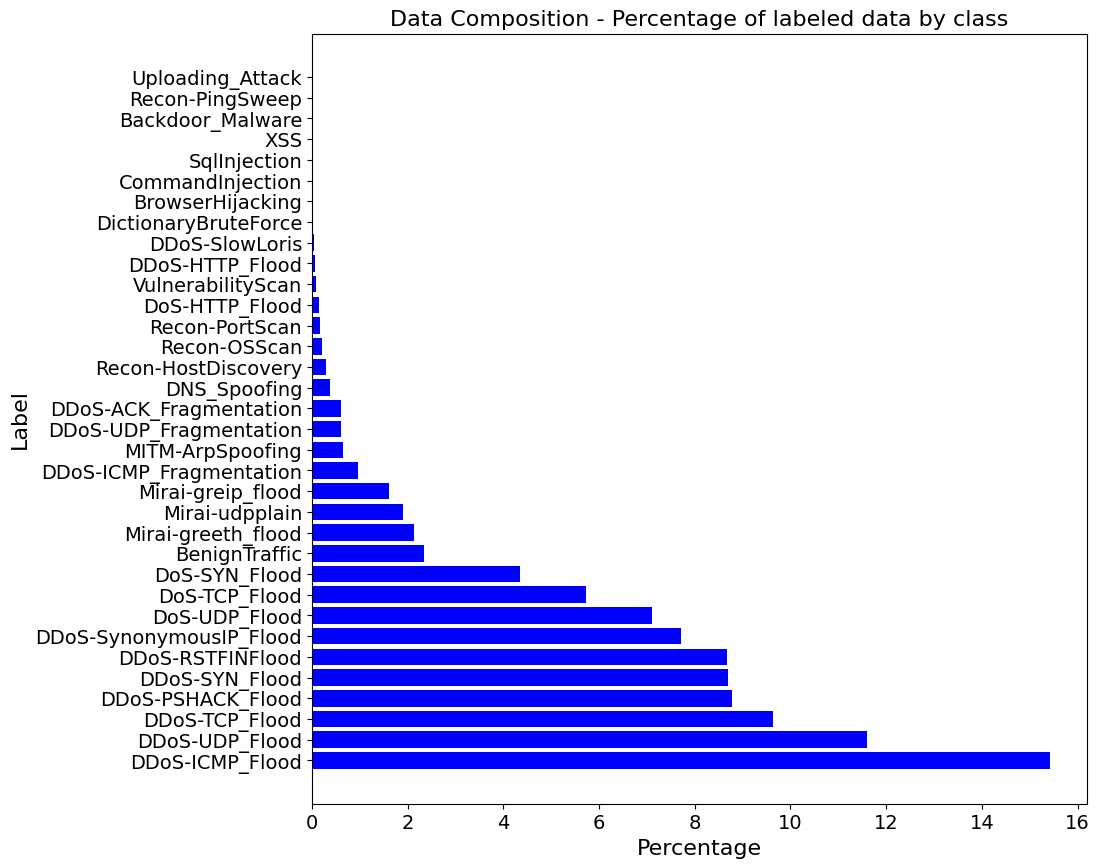

In [ ]:
#Distribuição dos dados
barh_plot(df, column_name = "label")

# Predicting models

# Data balancing
Cost-Sensitive Learning: Assigning higher weights to misclassifications of minority class examples during training, forcing the model to pay more attention to learning from them.




*   Calculate "Class_distribution" as the proportion of each class in dataset
*   A weight is attribute to each class label
the weight is calculated as the inverse proportion other distribution as classes in minor proportion get the major weight





In [ ]:
# Calcular a distribuição de classes no conjunto de treino
class_distribution = Y_train.value_counts(normalize=True)
# Definir o peso para cada classe com base na sua distribuição
class_weights = {cls: 1 / proportion for cls, proportion in class_distribution.items()} # Create a dictionary mapping class labels to weights


A decision tree is a hierarchical model that divides the data space into increasingly smaller subsets, aiming to identify patterns and rules for classifying or predicting values of a target variable. Each node of the tree represents a decision, dividing the data into branches based on specific values of features.

Algorithm Steps:


*   Division Criterion Selection: A criterion is chosen that evaluates the quality of the division, such as entropy, information gain, or Gini impurity. The goal is to divide the data in a way that maximizes the purity of the classes in each node.
*   Tree Growth: The tree is built recursively, dividing the data at each node until a stopping criterion is reached, such as maximum depth, minimum number of samples in a node, or a satisfactory level of purity.
*  Tree Pruning: To avoid overfitting and improve generalization, pruning techniques can be applied, removing branches that do not significantly contribute to the accuracy of the model.





*   Accuracy : Accuracy measures the overall correctness of the model's predictions on a test dataset.
*   Precision: the ratio between the number of true positives and the total number of positive predictions made by the model (true positives and false positives).
*   Recall : is measure used to evaluate how much a model identify positive cases. average="Weighted": This argument specifies how the recall score is calculated across multiple classes, if applicable. "Weighted" means the recall is averaged weighted across all classes. Useful when for imbalanced class distributions and want  giving more weight to the majority class.

*    The F1-score is the harmonic mean between precision and recall. It is a commonly used metric in machine learning to evaluate the performance of a classifier, **particularly in binary classification tasks**.








Best" Splitting Strategy: searches for the feature and threshold that best separates the data at each node in the tree. It aims to maximize the information gain or Gini impurity reduction, leading to a more efficient and accurate decision tree.


In [ ]:
DT = DecisionTreeClassifier(class_weight=class_weights, splitter='random')
start = time.time()
DT.fit(X_train, Y_train)
y_pred = DT.predict(X_test)
end = time.time()
time_elapsed = end - start

In [ ]:
results = calc_metrics(model_name = "Decision_tree_balanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [ ]:
print("Decision_tree_balanced :"+ results)

{'model_name': 'Decision_tree_balanced',
 'start_time': 1717892899.5535707,
 'end_time': 1717893205.4698403,
 'accuracy': 0.8203118540702703,
 'recall': 0.8203118540702703,
 'precision': 0.8349727617120626,
 'f1-score': 0.8219056187963752}

In [ ]:
joblib.dump(DT, path +'Decision_tree_balanced.joblib')
report = classification_report(Y_test, y_pred, digits = 3)


In [ ]:
print("Decision_tree_balanced :")
print(report)

                         precision    recall  f1-score   support

       Backdoor_Malware      0.092     0.105     0.098       658
          BenignTraffic      0.838     0.834     0.836    219431
       BrowserHijacking      0.230     0.256     0.243      1234
       CommandInjection      0.210     0.240     0.224      1082
 DDoS-ACK_Fragmentation      0.962     0.963     0.963     56912
        DDoS-HTTP_Flood      0.300     0.747     0.428      5726
        DDoS-ICMP_Flood      0.980     0.892     0.934   1439569
DDoS-ICMP_Fragmentation      0.287     0.698     0.407     90058
      DDoS-PSHACK_Flood      0.999     0.998     0.999    818506
       DDoS-RSTFINFlood      0.999     0.999     0.999    810294
         DDoS-SYN_Flood      0.689     0.876     0.771    812769
         DDoS-SlowLoris      0.557     0.575     0.566      4605
DDoS-SynonymousIP_Flood      0.880     0.656     0.752    720501
         DDoS-TCP_Flood      0.799     0.948     0.867    899595
         DDoS-UDP_Flood 

In [ ]:
#score = DT.score(X_test,Y_test)
#cm = confusion_matrix(Y_test, y_pred)
#categories = np.unique(np.concatenate((Y_test, y_pred)))
#plot_confusion_matrix(cm, classes=categories, normalize=True, title='Confusion Matrix')

Setting the splitter argument to "random" is a strategy sometimes used to address this bias in imbalanced datasets.

In [ ]:
DT_unbalanced = DecisionTreeClassifier(splitter='random')
start = time.time()
DT_unbalanced.fit(X_train, Y_train)
y_pred = DT_unbalanced.predict(X_test)
end = time.time()
time_elapsed = end - start
joblib.dump(DT_unbalanced, path +'Decision_tree_unbalanced.joblib')

['/content/drive/MyDrive/lab/CICIoT2023/Decision_tree_unbalanced.joblib']

In [ ]:
#load_model = joblib.load(path +'Decision_tree_unbalanced.joblib')
report =classification_report(Y_test, y_test)

In [ ]:
results = calc_metrics(model_name = "Decision_tree_unbalanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [ ]:
print("Decision_tree_unbalanced results:")
print(results)

{'model_name': 'Decision_tree_unbalanced',
 'start_time': 1717894002.2469916,
 'end_time': 1717894257.6898036,
 'accuracy': 0.8363746070069814,
 'recall': 0.8363746070069814,
 'precision': 0.8415262058493846,
 'f1-score': 0.8297371600187279}

In [ ]:
print("Decision_tree_unbalanced report:")
print(report)

In [ ]:
joblib.dump(DT, path +'Decision_tree_unbalanced.joblib')

0           DDoS-PSHACK_Flood
1             DDoS-ICMP_Flood
2              Mirai-udpplain
3              DDoS-UDP_Flood
4               DoS-SYN_Flood
                  ...        
46686574       DDoS-UDP_Flood
46686575        DoS-TCP_Flood
46686576      DDoS-ICMP_Flood
46686577       DDoS-UDP_Flood
46686578        DoS-SYN_Flood
Name: label, Length: 46686579, dtype: object

#Oversampling


Oversampling for handle unbalanced classes

*   SMOTE (Synthetic Minority Over-sampling Technique)



In [ ]:
from imblearn.over_sampling import SMOTE
X = X_train
y = Y_train

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')
gc.collect()

In [ ]:
DT_sampled = DecisionTreeClassifier()
start = time.time()
DT_sampled.fit(X_train, Y_train)
y_pred = DT_sampled.predict(X_test)
end = time.time()
time_elapsed = end - start
gc.collect()

In [ ]:
report =classification_report(Y_test, load_model.predict(X_test))

In [ ]:
results = calc_metrics(model_name = "Decision_tree_oversampled",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [ ]:
print("Decision_tree_oversampled results:")
print(results)
print("Decision_tree_oversampled report:")
print(report)
joblib.dump(DT, path +'Decision_tree_balanced.joblib')

#Predição sobre labels categorizados por tipo de ataque

In [ ]:
group_by_label = {
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Application',
    'Backdoor_Malware': 'Application',
    'XSS': 'Application',
    'Uploading_Attack': 'Application',
    'SqlInjection': 'Application',
    'CommandInjection': 'Application',
    'DictionaryBruteForce': 'BruteForce'
}

df['label'] = df['label'].apply(lambda x : group_by_label[x])
X_train, X_test, Y_train, Y_test = generate_train_test_split(df,X_columns, test_size=0.2, random_state=10)
gc.collect()


0

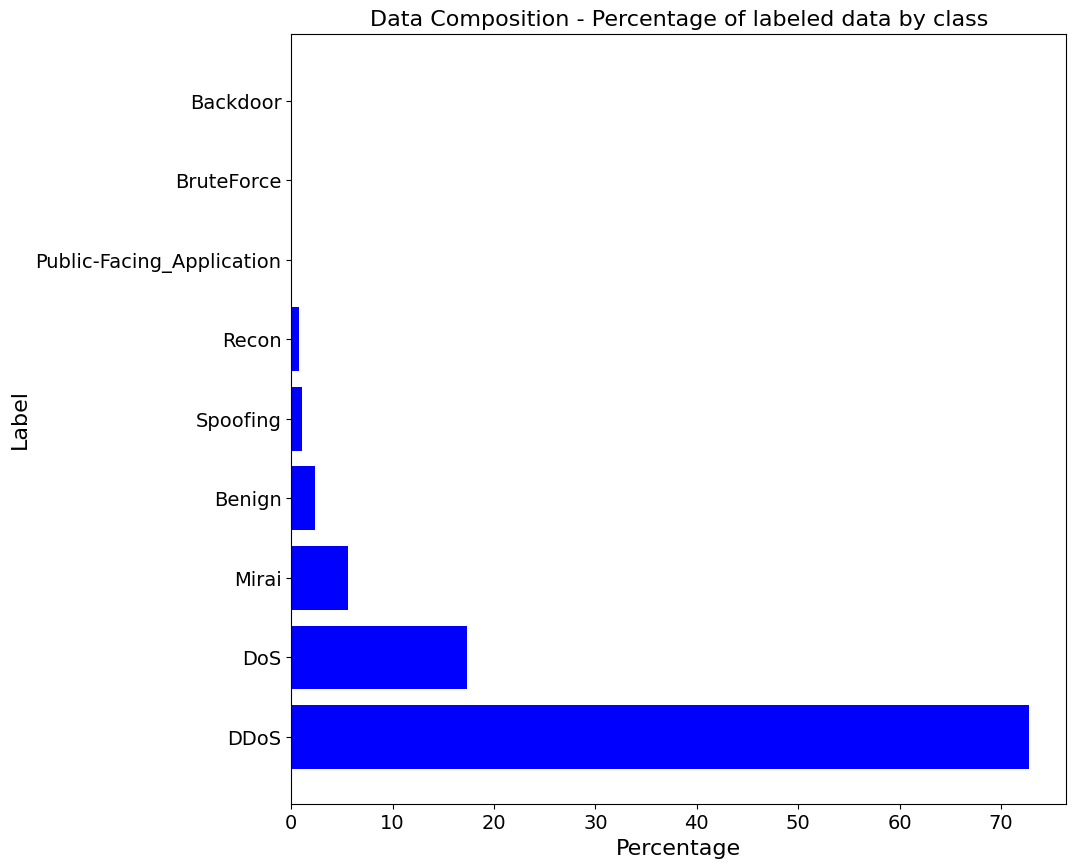

In [ ]:
barh_plot(df, column_name = "label")

In [ ]:
# Calcular a distribuição de classes no conjunto de treino
class_distribution = Y_train.value_counts(normalize=True)
# Definir o peso para cada classe com base na sua distribuição
class_weights = {cls: 1 / proportion for cls, proportion in class_distribution.items()} # Create a dictionary mapping class labels to weights


In [ ]:
DT = DecisionTreeClassifier(class_weight=class_weights, splitter='random')
start = time.time()
DT.fit(X_train, Y_train)
y_pred = DT.predict(X_test)
end = time.time()
time_elapsed = end - start
results = calc_metrics(model_name = "Decision_tree_unbalanced",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)
report =classification_report(Y_test, y_test)

In [ ]:
report =classification_report(Y_test, y_pred)

In [ ]:
results

In [ ]:
print(report)

              precision    recall  f1-score   support

 Application       0.24      0.24      0.24      5034
      Benign       0.84      0.84      0.84    219431
  BruteForce       0.25      0.27      0.26      2529
        DDoS       0.93      0.85      0.89   6798416
         DoS       0.55      0.75      0.63   1618096
       Mirai       0.98      0.98      0.98    525788
       Recon       0.63      0.63      0.63     70982
    Spoofing       0.71      0.70      0.70     97040

    accuracy                           0.84   9337316
   macro avg       0.64      0.66      0.65   9337316
weighted avg       0.86      0.84      0.85   9337316



In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=10)
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

resampled_df = pd.DataFrame(X_train_res, columns=X_columns)
resampled_df['label'] = y_resampled

gc.collect()
resampled_df.value_counts('label')


In [ ]:
DT_sampled = DecisionTreeClassifier()
start = time.time()
DT_sampled.fit(X_train_res,Y_train_res)
y_pred = DT_sampled.predict(X_test)
end = time.time()
time_elapsed = end - start
gc.collect()

In [ ]:
results = calc_metrics(model_name = "Decision_tree_sampled_groupby",y_true =Y_test, y_pred=y_pred, start_time=start, end_time=end)

In [ ]:
report =classification_report(Y_test, y_pred)

In [ ]:
print("Decision_tree_sampled_groupby results:")
print(results)
print("Decision_tree_sampled_groupby report:")
print(report)
joblib.dump(DT, path +'Decision_tree_sampled_groupby.joblib')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(DT_sampled, param_grid, cv=5, n_iter=10)

# Fit the random search object to the data
random_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = random_search.best_params_

# Get the best model
best_model = random_search.best_estimator_

# Print the best parameters and model
print("Best parameters:", best_params)
print("Best model:", best_model)


In [8]:
pip freeze > requirements